In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [ ]:
import os
num_workers = os.cpu_count()

transformer = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = transformer,
    batch_size = 32,
    num_workers = num_workers
)

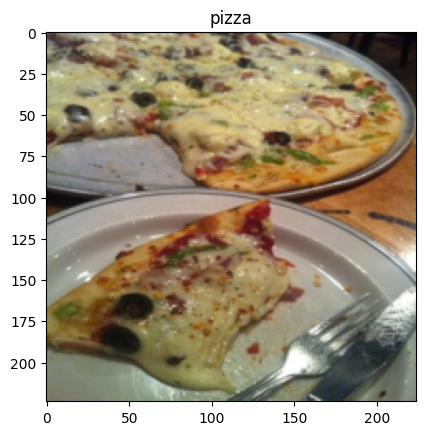

In [ ]:
sample_data, sample_label = next(iter(train_dataloaders))
plt.imshow(sample_data[0].permute(1,2,0))
plt.title(class_names[sample_label[0]])
plt.show()

# Start the replication

## Transforming a single image (for the sake of visualization)

In [ ]:
single_sample_data_tensor = sample_data[0]
single_sample_data = sample_data[0].permute(1,2,0)
single_sample_data_tensor.shape, single_sample_data.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

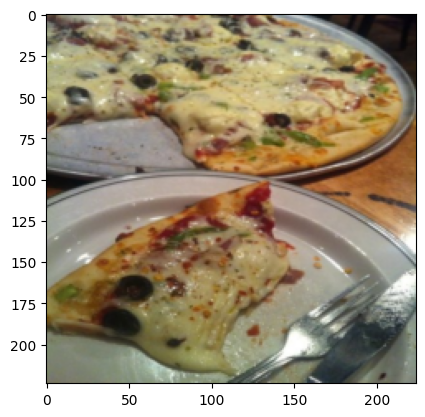

In [ ]:
plt.imshow(single_sample_data)
plt.show()

In [ ]:
height = 224  # H
width = 224   # W
channel = 3   # C
patch = 16    # P
number_of_patches = int((height * width) / patch**2)  # N = H*W/P^2

# H x W x C -> N x (P^2 * C)
print(f'{height} x {width} x {channel} -> {number_of_patches} x {channel*(patch**2)}')

224 x 224 x 3 -> 196 x 768


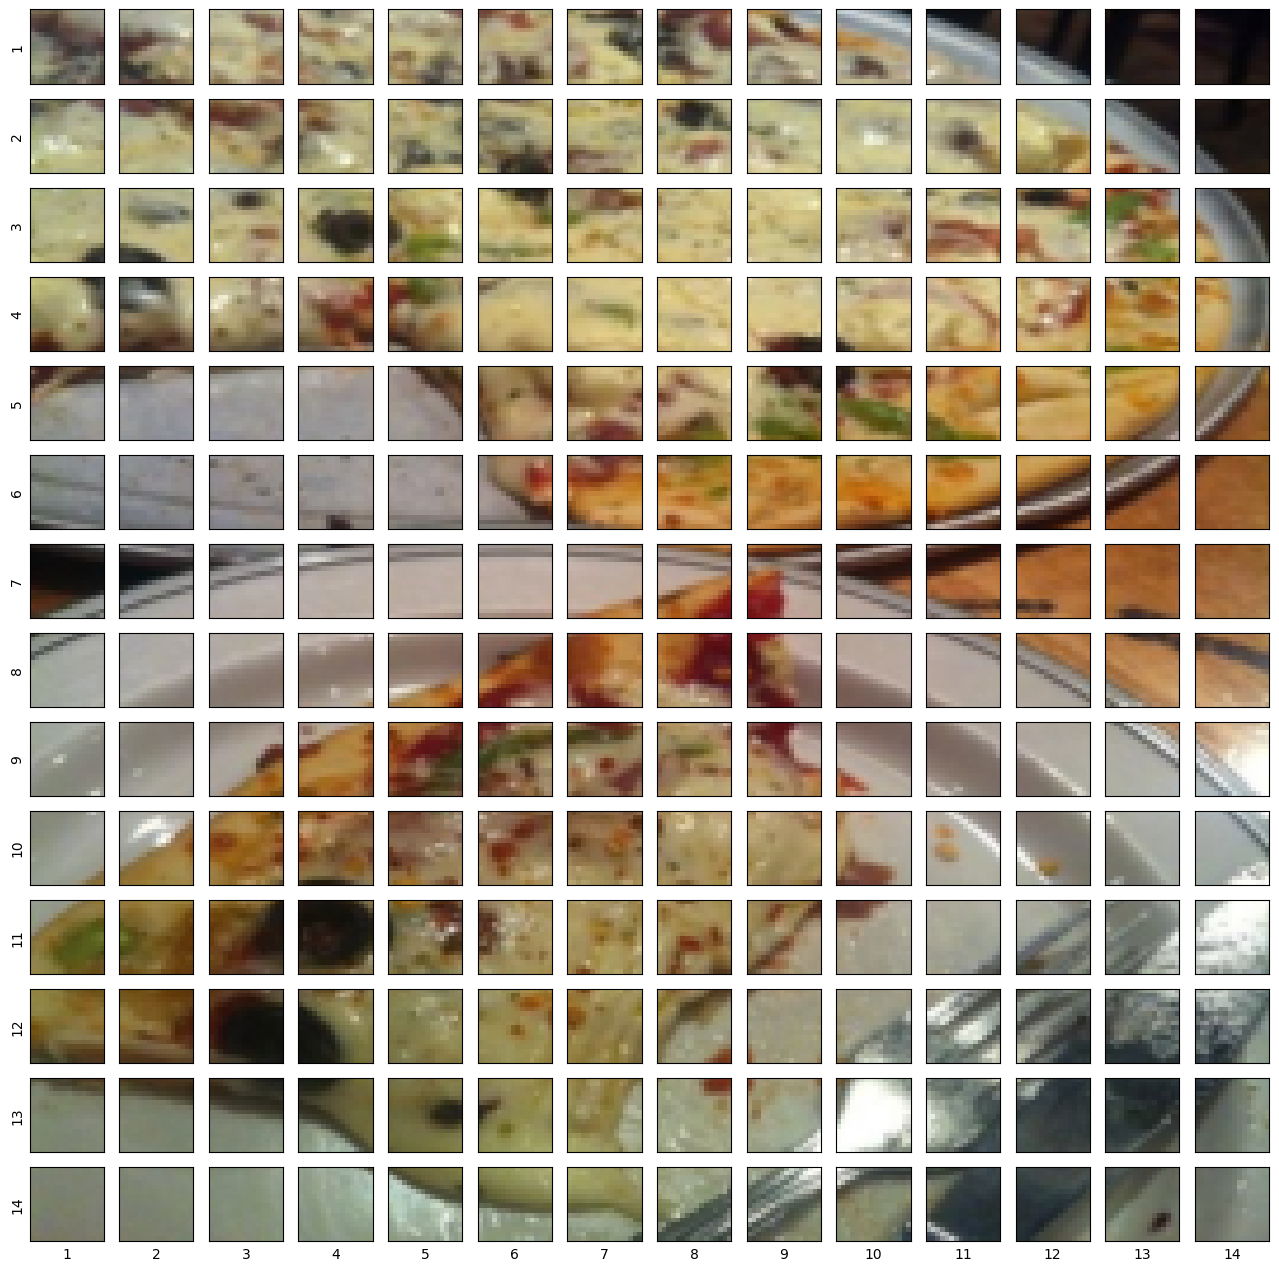

In [ ]:
image_height = int(height/patch)
image_width = int(width/patch)

# plot
fig, axes = plt.subplots(nrows=image_height, ncols=image_width, sharex=True, sharey=True, figsize=(patch,patch))
for i in range(image_height):
  for j in range(image_width):
    axes[i][j].imshow(single_sample_data[i*patch:(i+1)*patch,j*patch:(j+1)*patch,:])
    axes[i][j].set(xlabel='',ylabel='',title='')
    if j == 0:
      axes[i][j].set_ylabel(i+1)
    if i == image_height - 1:
      axes[i][j].set_xlabel(j+1)
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])
plt.show()

### CNN block

In [ ]:
patch_size = 16
D = 768

cnn_block = nn.Conv2d(
    in_channels=3,
    out_channels=D,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

single_sample_data_cnn = cnn_block(single_sample_data_tensor)
print(single_sample_data_tensor.shape, '->', single_sample_data_cnn.shape)

torch.Size([3, 224, 224]) -> torch.Size([768, 14, 14])


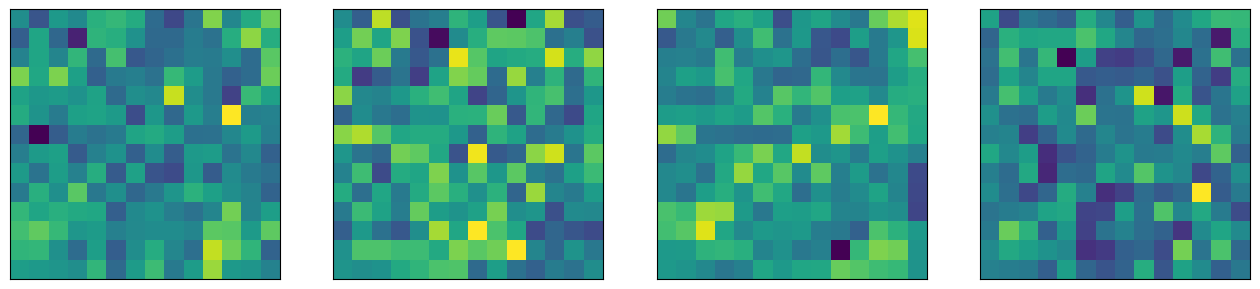

In [ ]:
# visualize 4 random hidden unit representation
import random
idx = random.sample(range(0,768),4)
fig, axs = plt.subplots(1,4,figsize=(16,4))
for id, num in enumerate(idx):
  axs[id].imshow(single_sample_data_cnn.detach().numpy()[num,:,:])
  axs[id].set_xticks([])
  axs[id].set_yticks([])

#### Try with 3 hidden layers for fun (visualization)

torch.Size([3, 224, 224]) -> torch.Size([3, 14, 14])


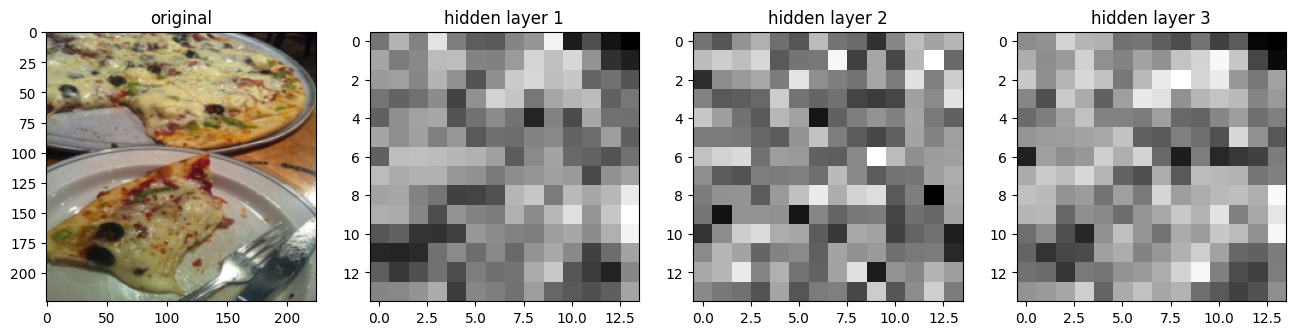

In [ ]:
cnn_block_fake = nn.Conv2d(
    in_channels=3,
    out_channels=3,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

single_sample_data_cnn_fake = cnn_block_fake(single_sample_data_tensor)
print(single_sample_data_tensor.shape, '->', single_sample_data_cnn_fake.shape)

# visualize 4 random hidden unit representation
fig, axs = plt.subplots(1,4,figsize=(16,4))
axs[0].imshow(single_sample_data)
axs[0].set_title('original')
for id in range(3):
  axs[id+1].imshow(single_sample_data_cnn_fake.permute(1,2,0).detach().numpy()[:,:,id], cmap='gray')
  axs[id+1].set_title(f'hidden layer {id+1}')

------------------------------------------------------------------------------------------------------------------------------

### Flatten block

torch.Size([768, 14, 14]) -> torch.Size([768, 196])


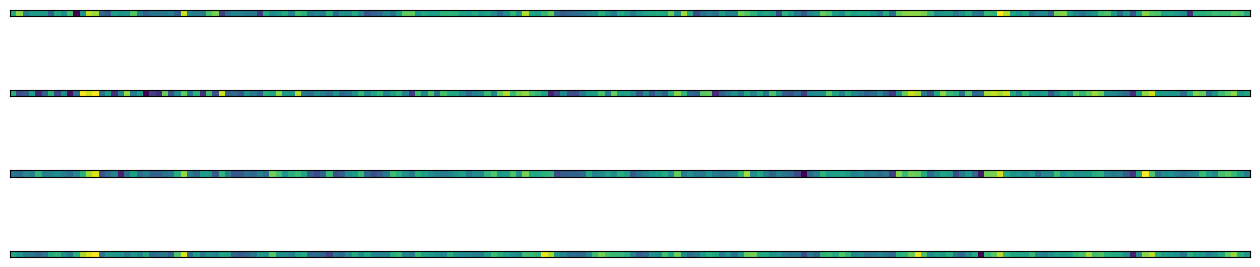

In [ ]:
# Flatten block
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
single_sample_data_flatten = flatten_layer(single_sample_data_cnn)
print(single_sample_data_cnn.shape, '->', single_sample_data_flatten.shape)

# Visualize the above 4 samples
fig, axs = plt.subplots(4,1,figsize=(16,4))
for id, num in enumerate(idx):
  axs[id].imshow(single_sample_data_flatten.detach().numpy()[num-1:num,:])
  axs[id].set_xticks([])
  axs[id].set_yticks([])

## Put everything together to create PatchEmbedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_shape=3, embedding_dim=768, patch_size=16):
    super().__init__()
    self.cnn_layer = nn.Conv2d(
        in_channels=in_shape,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size
      )
    self.flatten_layer = nn.Flatten(
        start_dim=2,
        end_dim=3
    )
  def forward(self, x):
    return self.flatten_layer(self.cnn_layer(x)).permute(0,2,1) # B x N x P^2 * C

# instantiate
patchify = PatchEmbedding().to(device)

# summary
summary(patchify, input_size=[32, 3, 224, 224], col_names=['input_size', 'output_size', 'trainable'])

# example
for X,y in train_dataloaders:
  break
patched_sample = patchify(X.to(device))
print(f'{sample_data.shape} -> {patched_sample.shape}')

torch.Size([32, 3, 224, 224]) -> torch.Size([32, 196, 768])


In [ ]:
# creating x_class
class_embedding = nn.Parameter(torch.rand([32, 1, 768]), requires_grad=True).to(device)

# concat
patched_sample_with_class_embedding = torch.concat([patched_sample, class_embedding], dim=1)
patched_sample_with_class_embedding.shape # B x (N+1) x D

torch.Size([32, 197, 768])

In [ ]:
# creating positional embedding of size B x (N+1) x D
positional_embedding = nn.Parameter(torch.rand([32, 197, 768]), requires_grad=True).to(device)

# sum
patch_and_positioned_embedding = patched_sample_with_class_embedding + positional_embedding
patch_and_positioned_embedding.shape # [B x (N+1) x D] + [B x (N+1) x D] -> B x (N+1) x D

torch.Size([32, 197, 768])

# Equation 1 - put everything together
Now let's put everything together to go from $\mathbf{x}$ -> $\mathbf{x_p}$ -> $\mathbf{z_0}$

$$z_0 = \left[ x_{\text{class}} ; x^1_pE; x^2_pE; \ldots ; x^N_pE \right] + E_{\text{pos}}, where$$ $ \quad E \in \mathbb{R}^{(P^2C) \times D}, \quad E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}, \quad \mathbf{x} \in \mathbb{R}^{H \times W \times C}, \quad \mathbf{x_p} \in \mathbb{R}^{N \times P^2C}, \quad \mathbf{x_\text{class}} \in \mathbb{R}^{1 \times D} \text{ and } N=H*W/P^2, D=768$

In [ ]:
# patch size
patch_size = 16
height = sample_data[0].shape[1]
width = sample_data[0].shape[2]
channels = sample_data[0].shape[0]
embedding_dim = 768
patch_count = int(sample_data[0].shape[1]*sample_data[0].shape[2]/patch_size**2)
print(f'H={height}, W={width}, C={channels}, P={patch_size}, N={patch_count}, D={embedding_dim}')

# original data - x
x = sample_data[0].unsqueeze(0).to(device)
batch_size = x.shape[0]
print('x:\t',x.shape)

# patched data - x_p*E
patch_embedding = PatchEmbedding(in_shape=channels, embedding_dim=embedding_dim, patch_size=patch_size).to(device)
x_p_E = patch_embedding(x)
print('x_p*E:\t',x_p_E.shape)

# embedded patches - x_class
x_class = nn.Parameter(torch.rand([batch_size, 1, embedding_dim], requires_grad=True)).to(device)
x_embedded_patch = torch.concat([x_class, x_p_E], dim=1)
print('[x_class, x_p*E]:\t',x_embedded_patch.shape)

# positional embedding - E_p
e_p = nn.Parameter(torch.rand([batch_size, patch_count+1, embedding_dim], requires_grad=True)).to(device)
z_0 = x_embedded_patch + e_p
print('z_0:\t',z_0.shape)

H=224, W=224, C=3, P=16, N=196, D=768
x:	 torch.Size([1, 3, 224, 224])
x_p*E:	 torch.Size([1, 196, 768])
[x_class, x_p*E]:	 torch.Size([1, 197, 768])
z_0:	 torch.Size([1, 197, 768])


# Equation 2

In [ ]:
class MSABlock(nn.Module):
  def __init__(self, embedding_dim: int, num_heads: int=12, attn_dropout: int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.msa_layer = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)
  def forward(self, x):
    x = self.layer_norm(x)
    return self.msa_layer(query=x, key=x, value=x, need_weights=False)[0]

# try
multi_head_attn = MSABlock(embedding_dim=embedding_dim).to(device)
z_l_ = multi_head_attn(z_0)
print(z_l_.shape)

torch.Size([1, 197, 768])


# Equation 3

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int, mlp_size: int=3072, dropout: float=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

# try
mlp_block = MLPBlock(embedding_dim=embedding_dim).to(device)
z_l = mlp_block(z_l_)
print(z_l.shape)

torch.Size([1, 197, 768])


# Equation 2 + 3 -> Transformer block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dim: int, num_heads: int=12, attn_dropout: int=0, mlp_size: int=3072, mlp_dropout: float=0.1):
    super().__init__()
    self.msa_block = MSABlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)
  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

# try
trans_block = TransformerBlock(embedding_dim=embedding_dim).to(device)
z = trans_block(z_0)
print(f'{z_0.shape} -> {z.shape}')
summary(model=trans_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

torch.Size([1, 197, 768]) -> torch.Size([1, 197, 768])


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)           [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (msa_block)                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa_layer)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

In [ ]:
# in-built torch.nn.TransformerEncoderLayer()
torch_trans_block = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

summary(model=torch_trans_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# The Whole ViT class

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               n_classes: int,
               image_height: int=224,
               image_width: int=224,
               patch_size: int=16,
               number_channels: int=3,
               embedding_dim: int=768,
               num_transformer_layers: int=12,
               num_heads: int=12,
               attn_dropout: int=0,
               mlp_size: int=3072,
               mlp_dropout: float=0.1):
    super().__init__()

    # number of patches
    self.patch_num = int(image_height * image_width / patch_size ** 2)

    # class embedding
    self.class_embedding = nn.Parameter(torch.rand([1, 1, embedding_dim], requires_grad=True))

    # positional embedding
    self.positional_embedding = nn.Parameter(torch.rand([1, self.patch_num+1, embedding_dim], requires_grad=True))

    # patch embedding
    self.patch_embedding = PatchEmbedding(in_shape=number_channels, embedding_dim=embedding_dim, patch_size=patch_size)

    # transformer layer
    self.transformer_layer = nn.Sequential(*[TransformerBlock(embedding_dim=embedding_dim,
                                                              num_heads=num_heads,
                                                              attn_dropout=attn_dropout,
                                                              mlp_size=mlp_size,
                                                              mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # classifier layer
    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim), nn.Linear(in_features=embedding_dim, out_features=n_classes))

  def forward(self, x):
    # batch size
    batch_size = x.shape[0]

    # embeddings
    x = self.patch_embedding(x)
    class_embedding_ = self.class_embedding.expand(batch_size, -1, -1)
    x = torch.concat([class_embedding_, x], dim=1) + self.positional_embedding

    # transformers
    x = self.transformer_layer(x)

    # classifiers
    x = self.classifier(x[:,0]) # as states in the ViT paper section 3.1 (eq. 4)

    return x

vit = ViT(n_classes=len(class_names))
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (cnn_layer)                               [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Sequential (transformer_layer)                        [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerBlock (0)                             [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MSABlock (msa_block)                        [32, 197, 768]       [32, 197, 768]       2,363,904            True
│    

### Training

In [ ]:
# optimizer / loss
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

# train
results = engine.train(
    model=vit,
    train_dataloader=train_dataloaders,
    test_dataloader=test_dataloaders,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=7,
    device=device
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 40.8020 | train_acc: 0.2656 | test_loss: 11.2127 | test_acc: 0.5417
Epoch: 2 | train_loss: 33.1868 | train_acc: 0.2656 | test_loss: 7.5261 | test_acc: 0.5417
Epoch: 3 | train_loss: 14.1097 | train_acc: 0.2852 | test_loss: 9.0762 | test_acc: 0.1979
Epoch: 4 | train_loss: 7.3987 | train_acc: 0.3867 | test_loss: 2.8622 | test_acc: 0.1979
Epoch: 5 | train_loss: 2.9376 | train_acc: 0.2773 | test_loss: 2.1604 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.8403 | train_acc: 0.2773 | test_loss: 2.1488 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2676 | train_acc: 0.3359 | test_loss: 1.6874 | test_acc: 0.2604


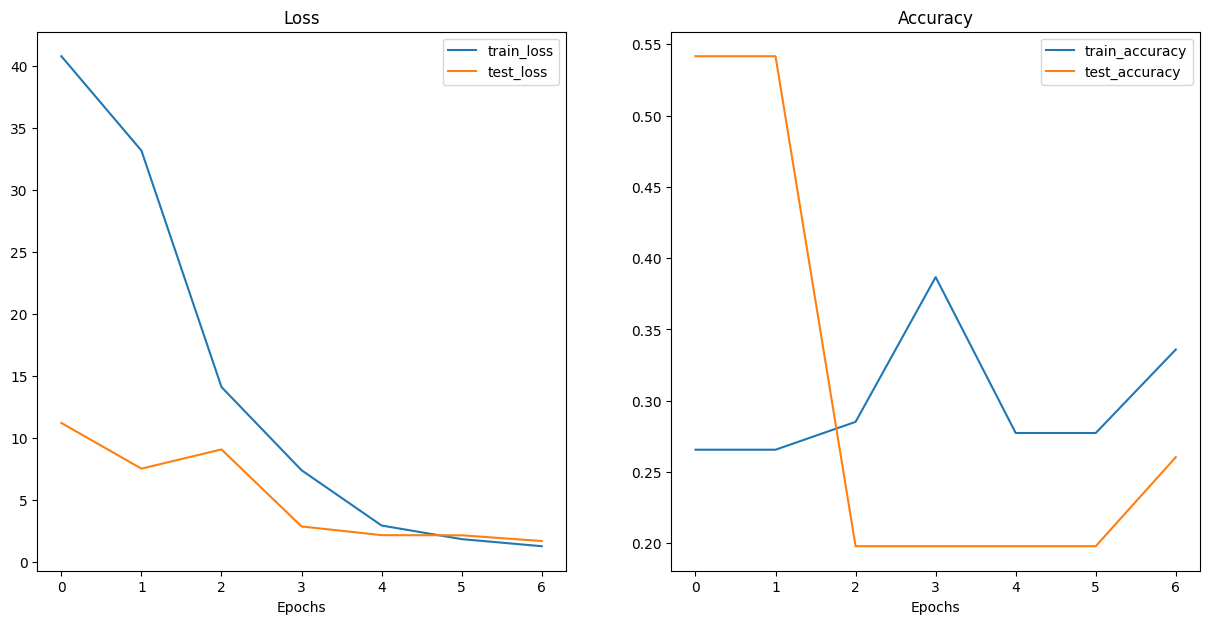

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

### Training pre-trained model

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Prepare the data

In [ ]:
train_dataloaders_pre_trained, test_dataloaders_pre_trained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms(),
    batch_size = 32,
    num_workers = num_workers
)

In [ ]:
# optimizer / loss
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

# train
results_pre_trained = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloaders_pre_trained,
    test_dataloader=test_dataloaders_pre_trained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 3.5786 | test_acc: 0.9479
Epoch: 2 | train_loss: 0.0428 | train_acc: 0.9961 | test_loss: 6.8083 | test_acc: 0.8778
Epoch: 3 | train_loss: 0.0405 | train_acc: 0.9922 | test_loss: 2.1590 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.0049 | train_acc: 0.9961 | test_loss: 2.4619 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.0351 | train_acc: 0.9961 | test_loss: 6.2698 | test_acc: 0.8371
Epoch: 6 | train_loss: 0.0534 | train_acc: 0.9922 | test_loss: 5.3742 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.1989 | train_acc: 0.9922 | test_loss: 3.9883 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 5.9249 | test_acc: 0.8674
Epoch: 9 | train_loss: 0.1417 | train_acc: 0.9883 | test_loss: 4.1968 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 5.8443 | test_acc: 0.9081


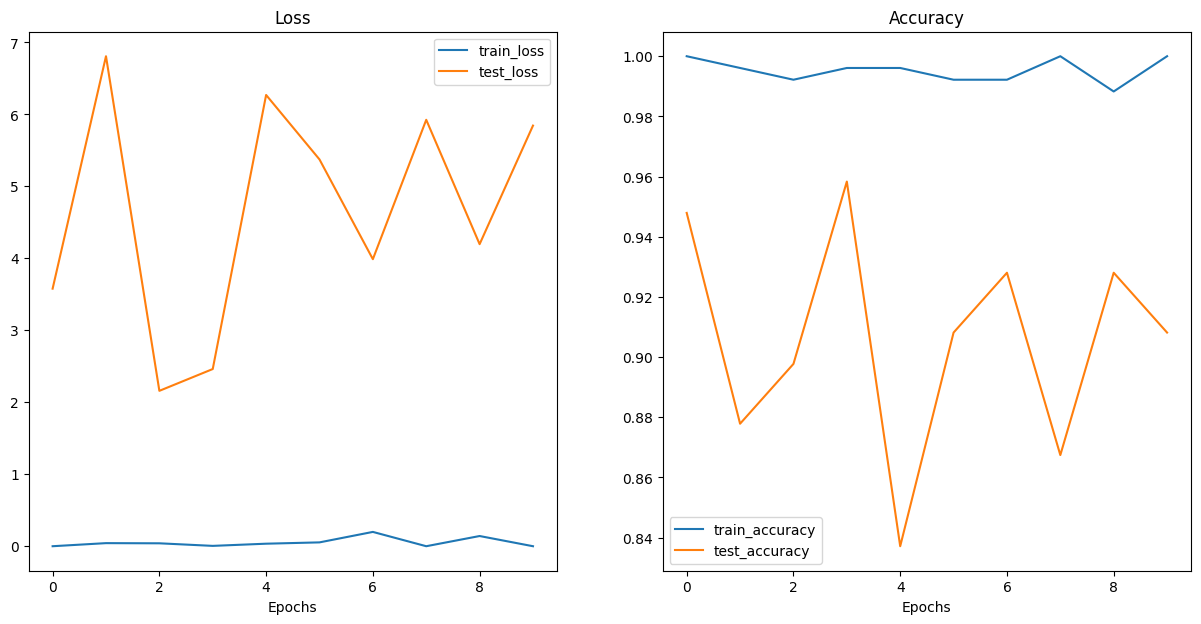

In [ ]:
# Plot our pre_trained ViT model's loss curves
plot_loss_curves(results_pre_trained)

In [ ]:
# Save the model
from going_modular.going_modular import utils
from pathlib import Path

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth
Pretrained ViT feature extractor model size: 327 MB
